In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import os
import pyproj
import nivapy
import imp
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata

sn.set_context('notebook')

In [2]:
# Import custom functions
spat_int_path = (r'C:\Data\James_Work\Staff\Leah_JB\ECCO-DomQua\Python'
                 r'\spatial_interpolation\spatial_interpolation.py')

spat_int = imp.load_source('spatial_interpolation', spat_int_path)

In [3]:
# Connect to db
ora_eng = nivapy.da.connect(src='nivabase')

Username: ········
Password: ········
Connection successful.


In [4]:
# Search projects
prj_df = nivapy.da.search_projects("project_name LIKE 'Regional%'", ora_eng)
prj_df

,project_id,project_number,project_name,contact_person,project_description
0,27,None,Regionalundersøkelse 1995,RESA,Tusensjøersundersøkelsen 1995 med etterfølgend...
1,81,None,Regionalundersøkelse 1986,None,Tusensjøers undersøkelsen 1986 samt nyere data...


In [5]:
# Get stations for 1995
stn_df = nivapy.da.select_project_stations([27,], ora_eng)

print 'Number of stations:', len(stn_df)
stn_df.head()

Number of stations: 1006


,station_id,station_code,station_name,latitude,longitude,altitude
0,115,831-501,BrÃ¥rvatn,59.294921,7.727118,902.0
1,116,1640-603,Tufsingen,62.612294,11.876558,781.0
2,125,2030-607,St.Valvatnet,69.694975,30.656211,157.0
3,135,1228-501,Steinavatn,59.859877,6.578783,1047.0
4,166,1018-4,Kleivsetvannet,58.119559,7.664899,93.0


In [6]:
# Add station locs to choropleth
map1 = nivapy.spatial.quickmap(stn_df, popup='both')
map1

In [7]:
# Pars of interest
par_list = ['Ag', 'As', 'Pb', 'Cd', 'Cu', 'Zn', 'Ni', 'Cr', 'Hg']

# Container for results
df_list = []

# Loop over stations
for stn_id in stn_df['station_id']:
    # Get all Al data
    wc_df, dup_df = nivapy.da.extract_water_chem(stn_id, par_list,
                                                 '1995-01-01', 
                                                 '1995-12-31',
                                                 ora_eng,
                                                 plot=False)
    
    # Tidy
    wc_df['station_id'] = stn_id
    wc_df.reset_index(inplace=True)
    df_list.append(wc_df)  

# Combine output
wc_df = pd.concat(df_list, axis=0)

#  Annual means for each site
wc_df['year'] = wc_df['sample_date'].dt.year
an_df = wc_df.groupby(['year', 'station_id']).mean()

# Reset index and join to stns
an_df.columns = [i.split('_')[0] for i in an_df.columns]
an_df.reset_index(inplace=True)
del an_df['year']

# Join and drop NaN
wc_df = pd.merge(stn_df[['station_id', 'latitude', 'longitude']],
                 an_df, how='left', on='station_id')
wc_df.dropna(subset=['latitude', 'longitude'], inplace=True)

wc_df.head()

,station_id,latitude,longitude,Ag,As,Cd,Cr,Cu,Ni,Pb,Zn
0,115,59.294921,7.727118,-0.01,NaN,0.03,-0.1,0.3,0.2,0.35,3.2
1,116,62.612294,11.876558,NaN,-0.1,-0.02,-0.1,-0.2,-0.1,0.05,0.9
2,125,69.694975,30.656211,NaN,NaN,NaN,NaN,2.0,6.0,NaN,NaN
3,135,59.859877,6.578783,NaN,NaN,0.02,0.5,1.5,0.2,4.09,2.1
4,166,58.119559,7.664899,-0.01,NaN,0.17,0.2,0.9,0.8,1.39,19.8


+a=6378137.0 +b=6356752.31425 +y_0=750000.0 +lon_0=15.0 +proj=aea +x_0=750000.0 +units=m +lat_2=74.5 +lat_1=54.5 +lat_0=64.5 


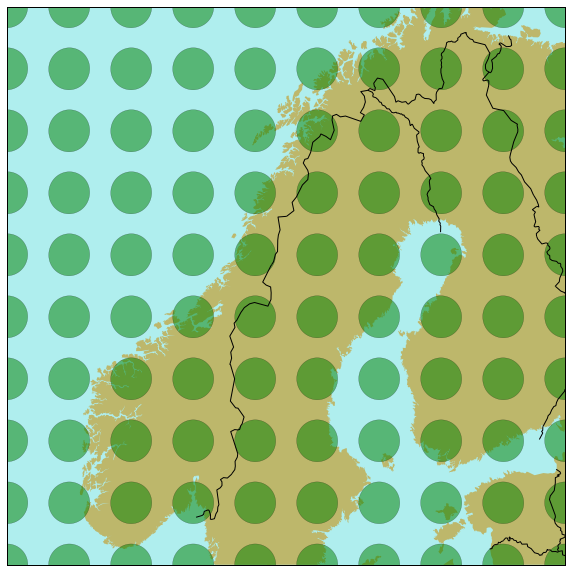

In [8]:
# Plot data to identify suitable projection parameters
fig = plt.figure(figsize=(10, 10))

# Use Albers Equal Area projection
m = Basemap(projection='aea',
            width=1500000,
            height=1500000,
            resolution='i',
            lat_1=54.5,          # 1st standard parallel
            lat_2=74.5,          # 2st standard parallel
            lon_0=15,lat_0=64.5, # Central point
            ellps='WGS84')     # http://matplotlib.org/basemap/api/basemap_api.html

# Add map components
m.fillcontinents (color='darkkhaki', lake_color='darkkhaki')
m.drawcountries(linewidth=1)
m.drawmapboundary(fill_color='paleturquoise')

# Draw Tissot indicatrices to show distortion
for y in np.linspace(m.ymin/20, m.ymax, 10):
    for x in np.linspace(m.xmin, m.xmax, 10):
        lon, lat = m(x, y, inverse=True)
        poly = m.tissot(lon, lat,           # Location
                        0.5,                # Radius in degrees
                        100,                # N pts used to draw indicatrix
                        facecolor='green',
                        alpha=0.5)

print m.proj4string

# Set up 25 km grid for interpolation
# Shift by (cell_size/2) s.t. values are estimated for the centre of each grid square
cell_size = 25000 # metres
gridx = np.arange(int(m.xmin), int(m.xmax), cell_size) + (cell_size/2.)
gridy = np.arange(int(m.ymin), int(m.ymax), cell_size) + (cell_size/2.)

In [9]:
# Hg not measured in 1995
par_list = ['Ag', 'As', 'Pb', 'Cd', 'Cu', 'Zn', 'Ni', 'Cr']

# Output folder
out_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\Metals\Raw_Datasets\Lakes_1000\Interpolated')

# Loop over years
for par in par_list: 
    df = wc_df[['latitude', 'longitude', par]].copy()
    df.dropna(how='any', inplace=True)    
    
    # Map (long, lat) to projected (x, y)
    x, y = m(df['longitude'].values, df['latitude'].values)

    # Reformat to synatx required by interp algorithms
    pts = np.array(zip(x ,y))

    # Get values to interpolate
    vals = df[par].values

    # IDW interpolation
    idw = spat_int.idw_interp(pts, vals, 
                              gridx, gridy, 
                              n_near=8, p=2)

    # Spline interpolation
    xx, yy = np.meshgrid(gridx, gridy) 
    spl = griddata(pts, vals, 
                   (xx, yy), 
                   method='cubic')
    spl[spl < 0] = 0

    # Save output
    # IDW
    idw_path = os.path.join(out_fold, 'lakes_1k_%s_idw_n8_p2.tif' % par)
    spat_int.array_to_gtiff(m.xmin, m.ymax, 25000, 
                            idw_path, idw, m.proj4string)
    
    # Spline
    spl_path = os.path.join(out_fold, 'lakes_1k_%s_spline.tif' % par)
    spat_int.array_to_gtiff(m.xmin, m.ymax, 25000, 
                            spl_path, spl, m.proj4string)

C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:32: RuntimeWarning: invalid value encountered in less
C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\osgeo\gdal.py:116: DeprecationWarning: gdal.py was placed in a namespace, it is now available as osgeo.gdal
  DeprecationWarning)


C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: invalid value encountered in less_equal


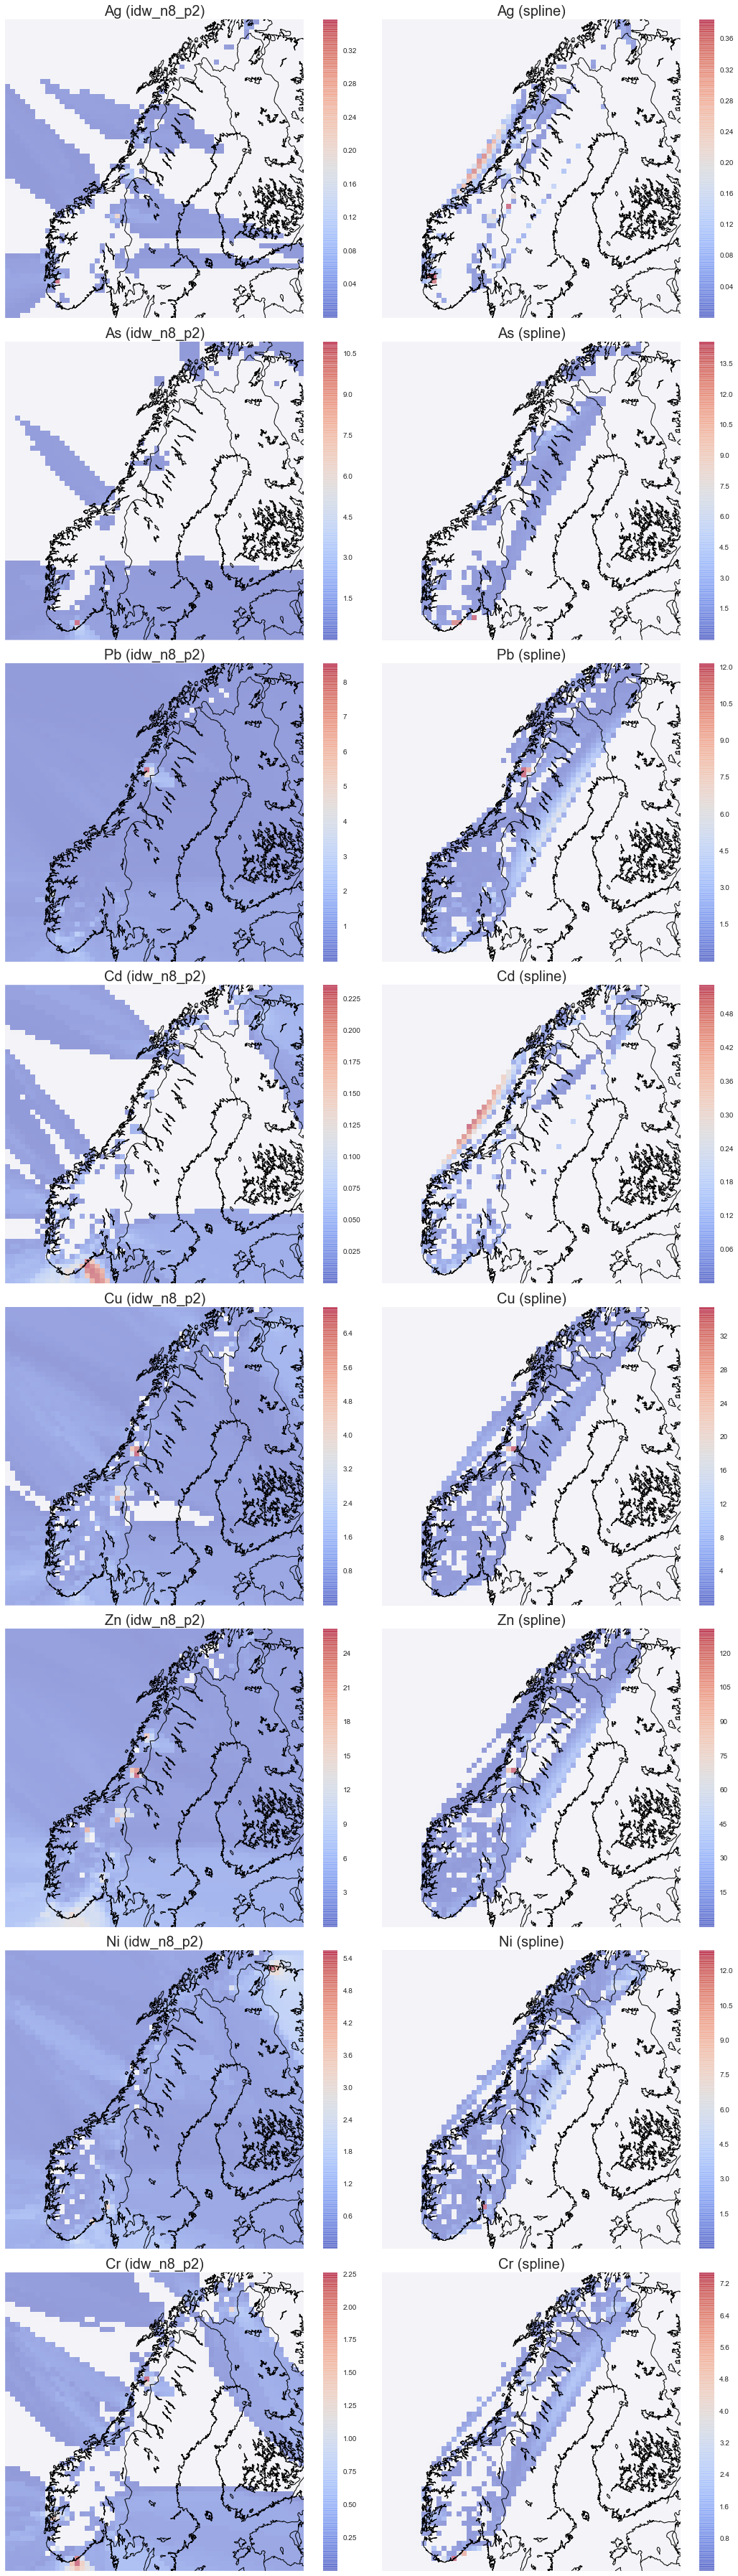

In [10]:
# Data folder
data_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\NOPE\Metals\Raw_Datasets\Lakes_1000\Interpolated')

fig = plt.figure(figsize=(15, 50))
cnt = 0

for par in par_list:
    for meth in ['idw_n8_p2', 'spline']:
        cnt += 1
        
        # Read data
        gtiff_path = os.path.join(data_fold, 'lakes_1k_%s_%s.tif' % (par, meth))
        data = spat_int.read_geotiff(gtiff_path)[0]
        
        # Set NaN
        data[data <=0] = np.nan

        # Use defined colour for NaN. See:
        # https://stackoverflow.com/a/2578873/505698
        masked_array = np.ma.array (data, mask=np.isnan(data))
        cmap = matplotlib.cm.coolwarm
        cmap.set_bad('white', 1.)

        # Plot
        ax = fig.add_subplot(8, 2, cnt)
        ax.set_title('%s (%s)' % (par, meth), fontsize=20)
        cax = m.imshow(masked_array, 
                       cmap=cmap, alpha=0.5, 
                       interpolation='none')
        m.drawcoastlines(linewidth=1)
        m.drawcountries(linewidth=1)
        cbar = fig.colorbar(cax)

plt.tight_layout()